In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from vae_interp.vae import VAE
from vae_interp.dataset import NpyDataset
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import torch
from vae_interp.sae import SAE

/home/ubuntu/.cache/pypoetry/virtualenvs/nouns-mech-interp-YeAXWnnL-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = NpyDataset("./vae_embeddings.npy")
dataset[0].shape

torch.Size([64])

In [4]:
vae = VAE.load_from_dir("./checkpoints/vae")
vae.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (mu_logvar): Conv2d(256, 8, kernel_siz

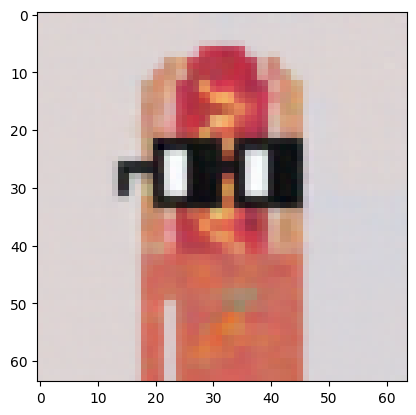

In [5]:
decoded = vae.decode(dataset[0].view(1, 4, 4, 4)).detach().numpy().squeeze(0).transpose(1, 2, 0)
normalized = (decoded - decoded.min()) / (decoded.max() - decoded.min())

plt.imshow(normalized)

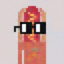

In [6]:
# latent = torch.randn(1, 4, 4, 4)
latent = dataset[0].view(1, 4, 4, 4)
decoded = vae.decode(latent).detach().squeeze(0)
decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
image = ToPILImage()(decoded)
image

In [7]:
sae = SAE.load_from_checkpoint("./checkpoints/sae_experiments2/lr=5.0e-04_l1=1.0e-03/sae_config.json",
                               "./checkpoints/sae_experiments2/lr=5.0e-04_l1=1.0e-03/sae.pth")
sae.eval()

SAE()

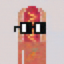

In [8]:
recon_latent = sae(latent.view(1, -1)).recon.view(1, 4, 4, 4)
decoded = vae.decode(recon_latent).detach().squeeze(0)
decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
image = ToPILImage()(decoded)
image

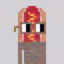

In [42]:
latent = dataset[0].view(1, 4, 4, 4)
latent_flat = latent.view(1, -1)
sparse_latent = sae.encode(latent_flat)

sparse_latent[0, 2] = 0
sparse_latent[0, 82] = 0
sparse_latent[0, 136] = 0
sparse_latent[0, 164] = 0
sparse_latent[0, 164] = 0
sparse_latent[0, 204] = 0
sparse_latent[0, 211] = 0
sparse_latent[0, 215] = 0
sparse_latent[0, 227] = 0
sparse_latent[0, 263] = 0
sparse_latent[0, 296] = 0
sparse_latent[0, 297] = 0
sparse_latent[0, 315] = 0
sparse_latent[0, 317] = 0
sparse_latent[0, 355] = 0
sparse_latent[0, 381] = 0
sparse_latent[0, 400] = 0
sparse_latent[0, 410] = 0
sparse_latent[0, 450] = 0
sparse_latent[0, 455] = 3
sparse_latent[0, 466] = 0

# print(sparse_latent)

recon_latent = sae.decode(sparse_latent).view(1, 4, 4, 4)
# recon_latent = (sae.features[2] + sae.b_d).view(1, 4, 4, 4)
decoded = vae.decode(recon_latent).detach().squeeze(0)
decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
image = ToPILImage()(decoded)
image

In [31]:
sparse_latent[0, 455]

tensor(2.8062, grad_fn=<SelectBackward0>)

In [11]:
# get idx that do not equal zero

sparse_latent = sae(latent.view(1, -1)).latent.view(-1)
nonzero_indices = torch.nonzero(sparse_latent).view(-1)

nonzero_indices

tensor([  2,  82, 136, 164, 195, 204, 211, 215, 227, 263, 296, 297, 315, 317,
        355, 381, 400, 410, 450, 455, 466])

In [151]:
sparse_latent[nonzero_indices]

tensor([4.8949e-02, 7.7902e-02, 1.7649e-02, 1.4649e-01, 3.9363e-02, 2.5880e-03,
        2.3241e-01, 2.5645e-01, 2.1877e-01, 1.8927e-01, 1.5569e-01, 1.1677e-01,
        2.3409e-01, 2.2006e-01, 3.1324e-01, 1.0168e-01, 6.5842e-02, 2.0721e-01,
        2.2286e-01, 2.8062e+00, 4.0281e-01], grad_fn=<IndexBackward0>)

In [157]:
feature = sae.features[nonzero_indices] * sparse_latent[nonzero_indices].view(-1, 1)
feature = feature.sum(dim=0)
feature.shape

torch.Size([64])

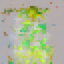

In [158]:
feature = feature.view(1, 4, 4, 4)
decoded = vae.decode(feature).detach().squeeze(0)
decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
image = ToPILImage()(decoded)
image

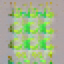

In [150]:
feature = sae.features[2].view(-1, 4, 4, 4) * 0.0489 + sae.features[82].view(-1, 4, 4, 4) * 0.0779
decoded = vae.decode(feature).detach().squeeze(0)
decoded = (decoded - decoded.min()) / (decoded.max() - decoded.min())
image = ToPILImage()(decoded)
image